# 三角板关键点检测预测-Python API

同济子豪兄 2023-4-4 5-24

## 进入 mmpose 主目录

In [1]:
import os
os.chdir('../MMPOSE/mmpose')

## 导入工具包

In [2]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [4]:
img_path = 'data/ear_images.jpg'

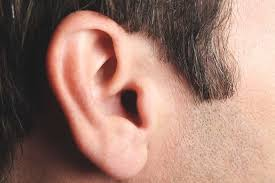

In [5]:
Image.open(img_path)

## 准备好的模型文件

## 构建目标检测模型（任选一个运行）

In [6]:
# RTMDet 三角板检测
detector = init_detector(
    'data/rtmdet_tiny_triangle.py',
    'checkpoint/rtmdet_tiny_ear_epoch_200_20230614.pth',
    device=device
)

Loads checkpoint by local backend from path: checkpoint/rtmdet_tiny_ear_epoch_200_20230614.pth


## 构建关键点检测模型

In [7]:
pose_estimator = init_pose_estimator(
    'data/rtmpose-s-ear.py',
    'checkpoint/rtmpose-s-ear-300.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by local backend from path: checkpoint/rtmpose-s-ear-300.pth


## 预测-目标检测

In [8]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

06/14 22:24:38 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [9]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

d:\miniconda\envs\openmmlab\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
detect_result.keys()

['pred_instances', 'gt_instances', 'ignored_instances']

In [11]:
# 预测类别
detect_result.pred_instances.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
# 置信度
detect_result.pred_instances.scores

tensor([0.8129, 0.0311, 0.0305, 0.0277, 0.0270, 0.0237, 0.0233, 0.0213, 0.0205,
        0.0205, 0.0190, 0.0181, 0.0167, 0.0165, 0.0164, 0.0158, 0.0153, 0.0152,
        0.0152, 0.0150, 0.0134, 0.0128, 0.0122, 0.0121, 0.0116, 0.0115, 0.0114,
        0.0112, 0.0112, 0.0112, 0.0111, 0.0111, 0.0111, 0.0110, 0.0109, 0.0105,
        0.0104, 0.0103, 0.0103, 0.0101, 0.0100, 0.0100, 0.0100, 0.0100, 0.0099,
        0.0098, 0.0098, 0.0097, 0.0097, 0.0097, 0.0096, 0.0094, 0.0093, 0.0092,
        0.0091, 0.0091, 0.0090, 0.0090, 0.0089, 0.0089, 0.0087, 0.0086, 0.0086,
        0.0086, 0.0085, 0.0083, 0.0083, 0.0083, 0.0082, 0.0082, 0.0082, 0.0081,
        0.0081, 0.0080, 0.0080, 0.0079, 0.0079, 0.0079, 0.0077, 0.0077, 0.0076,
        0.0075, 0.0075, 0.0074, 0.0074, 0.0074, 0.0073, 0.0073, 0.0072, 0.0072,
        0.0072, 0.0072, 0.0069, 0.0069, 0.0069, 0.0069, 0.0069, 0.0068, 0.0068,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0066, 0.0066, 0.0064, 0.0064, 0.0063,
        0.0063, 0.0063, 0.0063, 0.0063, 

In [16]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [13]:
# 置信度阈值
CONF_THRES = 0.5

In [14]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')

In [15]:
bboxes

array([[ 44,   5, 171, 183]])

## 预测-关键点

In [16]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

06/14 22:25:17 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


f:\C_TRANSFER\AI\AI_demo\DL\openmmlab\OpenMMlab_task1\MMPOSE\mmpose\mmpose\models\heads\coord_cls_heads\rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


In [17]:
len(pose_results)

1

In [18]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [19]:
data_samples.keys()

['pred_fields', 'pred_instances', 'gt_instances', '_pred_heatmaps']

## 预测结果-关键点坐标

In [20]:
keypoints = data_samples.pred_instances.keypoints.astype('int')

In [21]:
keypoints

array([[[137, 110],
        [ 85,  11],
        [100,  96],
        [127, 148],
        [122,  89],
        [ 94,  90],
        [117, 117],
        [120, 111],
        [112, 110],
        [125, 118],
        [111,  64],
        [ 99, 105],
        [104,  46],
        [ 94,  47],
        [104,  70],
        [143,  68],
        [155, 107],
        [166, 144],
        [ 83, 113],
        [128, 160],
        [ 84,  67]]])

In [22]:
keypoints.shape

(1, 21, 2)

In [23]:
# 索引为 0 的框，每个关键点的坐标
keypoints[0,:,:]

array([[137, 110],
       [ 85,  11],
       [100,  96],
       [127, 148],
       [122,  89],
       [ 94,  90],
       [117, 117],
       [120, 111],
       [112, 110],
       [125, 118],
       [111,  64],
       [ 99, 105],
       [104,  46],
       [ 94,  47],
       [104,  70],
       [143,  68],
       [155, 107],
       [166, 144],
       [ 83, 113],
       [128, 160],
       [ 84,  67]])

## 预测结果-关键点热力图

In [24]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(21, 183, 275)

In [25]:
kpt_idx = 1
heatmap = data_samples.pred_fields.heatmaps[kpt_idx,:,:]

In [26]:
heatmap.shape

(183, 275)

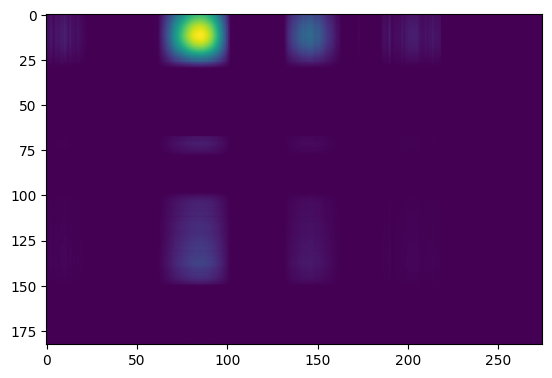

In [27]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## OpenCV可视化

In [28]:
img_bgr = cv2.imread(img_path)

In [29]:
# 检测框的颜色
bbox_color = (150,0,0)
# 检测框的线宽
bbox_thickness = 20
# 关键点半径
kpt_radius = 70
# 连接线宽
skeleton_thickness = 30

In [37]:
# 三角板关键点检测数据集-元数据（直接从config配置文件中粘贴）
dataset_info = {
    'dataset_name':'Ear210_Keypoint_Dataset_coco',
    'classes':'ear',
    'paper_info':{
        'author':'Tongji Zihao',
        'title':'Triangle Keypoints Detection',
        'container':'OpenMMLab',
        'year':'2023',
        'homepage':'https://space.bilibili.com/1900783'
    },
    'keypoint_info': {
        0: {'name': '肾上腺', 'id': 0, 'color': [101, 205, 228], 'type': '', 'swap': ''},
        1: {'name': '耳尖', 'id': 1, 'color': [240, 128, 128], 'type': '', 'swap': ''},
        2: {'name': '胃', 'id': 2, 'color': [154, 205, 50], 'type': '', 'swap': ''},
        3: {'name': '眼', 'id': 3, 'color': [34, 139, 34], 'type': '', 'swap': ''},
        4: {'name': '口', 'id': 4, 'color': [139, 0, 0], 'type': '', 'swap': ''},
        5: {'name': '肝', 'id': 5, 'color': [255, 165, 0], 'type': '', 'swap': ''},
        6: {'name': '对屏尖', 'id': 6, 'color': [255, 0, 255], 'type': '', 'swap': ''},
        7: {'name': '心', 'id': 7, 'color': [255, 255, 0], 'type': '', 'swap': ''},
        8: {'name': '肺', 'id': 8, 'color': [29, 123,243], 'type': '', 'swap': ''},
        9: {'name': '肺2', 'id': 9, 'color': [0, 255, 255], 'type': '', 'swap': ''},
        10: {'name': '膀胱', 'id': 10, 'color': [128, 0, 128], 'type': '', 'swap': ''},
        11: {'name': '脾', 'id': 11, 'color': [74, 181, 57], 'type': '', 'swap': ''},
        12: {'name': '角窝中', 'id': 12, 'color': [165, 42, 42], 'type': '', 'swap': ''},
        13: {'name': '神门', 'id': 13, 'color': [128, 128, 0], 'type': '', 'swap': ''},
        14: {'name': '肾', 'id': 14, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        15: {'name': '耳门', 'id': 15, 'color': [34, 139, 34], 'type': '', 'swap': ''},
        16: {'name': '听宫', 'id': 16, 'color': [255, 129, 0], 'type': '', 'swap': ''},
        17: {'name': '听会', 'id': 17, 'color': [70, 130, 180], 'type': '', 'swap': ''},
        18: {'name': '肩', 'id': 18, 'color': [63, 103,165], 'type': '', 'swap': ''},
        19: {'name': '扁桃体', 'id': 19, 'color': [66, 77, 229], 'type': '', 'swap': ''},
        20: {'name': '腰骶椎', 'id': 20, 'color': [255, 105, 180], 'type': '', 'swap': ''}
    }, 
    'skeleton_info': {
        0: {'link':('眼','扁桃体'),'id': 0,'color': [100,150,200]},
        1: {'link':('耳门','听宫'),'id': 1,'color': [200,100,150]},
        2: {'link':('听宫','听会'),'id': 2,'color': [150,120,100]},
        3: {'link':('耳门','听会'),'id': 3,'color': [66,77,229]}
    },
    'joint_weights':[1.0] * 21,
    'sigmas':[0.025] * 21
}

In [38]:
# 关键点类别和关键点ID的映射字典
label2id = {}
for each in dataset_info['keypoint_info'].items():
    label2id[each[1]['name']] = each[0]

In [39]:
for bbox_idx, bbox in enumerate(bboxes): # 遍历每个检测框

    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox[0], bbox[1]), (bbox[2], bbox[3]), bbox_color, bbox_thickness)
    
    # 索引为 0 的框，每个关键点的坐标
    keypoints = data_samples.pred_instances.keypoints[bbox_idx,:,:].astype('int')

    # 画连线
    for skeleton_id, skeleton in dataset_info['skeleton_info'].items(): # 遍历每一种连接
        skeleton_color = skeleton['color']
        srt_kpt_id = label2id[skeleton['link'][0]] # 起始点的类别 ID
        srt_kpt_xy = keypoints[srt_kpt_id]         # 起始点的 XY 坐标
        dst_kpt_id = label2id[skeleton['link'][1]] # 终止点的类别 ID
        dst_kpt_xy = keypoints[dst_kpt_id]         # 终止点的 XY 坐标
        img_bgr = cv2.line(img_bgr, (srt_kpt_xy[0],srt_kpt_xy[1]),(dst_kpt_xy[0],dst_kpt_xy[1]),color=skeleton_color,thickness=skeleton_thickness)
        
    # 画关键点
    for kpt_idx, kpt_xy in enumerate(keypoints): # 遍历该检测框中的每一个关键点
        kpt_color = dataset_info['keypoint_info'][kpt_idx]['color']
        img_bgr = cv2.circle(img_bgr, (kpt_xy[0], kpt_xy[1]), kpt_radius, kpt_color, -1)

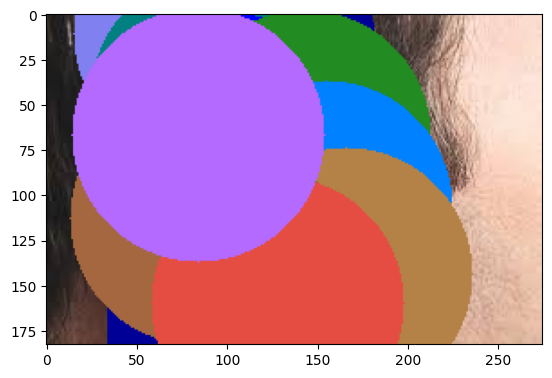

In [40]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [41]:
cv2.imwrite('outputs/G3_opencv.jpg', img_bgr)

True

## MMPose官方可视化工具`visualizer`

In [42]:
# 半径
pose_estimator.cfg.visualizer.radius = 50
# 线宽
pose_estimator.cfg.visualizer.line_width = 20
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

06/14 22:28:16 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [43]:
# 元数据
# pose_estimator.dataset_meta

In [44]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show=False,
            show_kpt_idx=True,
            wait_time=0,
            out_file='outputs/G3_visualizer.jpg',
            kpt_thr=0.3
)

In [45]:
img_output.shape

(366, 275, 3)

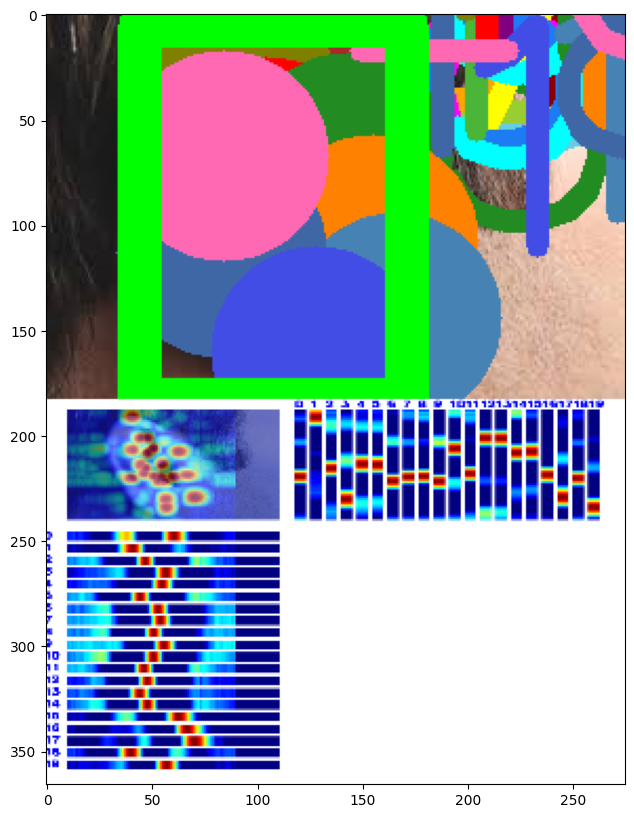

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(img_output)
plt.show()